In [12]:
import json
import w3d2_tests
import transformers
import torch
import torch as t
import einops
import math
import torch.nn.functional as F

model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:]


In [9]:
print(test_tokens)

tensor([[50257,   376, 32910,  ..., 50258, 50258, 50258],
        [50257,   383, 23020,  ...,   314,   373,  2252],
        [50257,  1318,   389,  ..., 50258, 50258, 50258],
        ...,
        [50257, 42272, 15773,  ..., 50258, 50258, 50258],
        [50257,   449,    54,  ...,   287,   262,  1578],
        [50257, 19020,  2198,  ...,   383, 19020,  6822]])


In [4]:
model

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

In [11]:
model.blocks[0].project_qkv

Linear(in_features=256, out_features=768, bias=False)

In [5]:

def contributions_to_attention(test_tokens, model):
    num_heads = model.blocks[0].n_heads
    hidden_size = model.blocks[0].hidden_size
    head_size = model.blocks[0].head_size
    batches, seq_len = test_tokens.shape
    device = test_tokens.device
    # terms = 4
    # data = torch.zeros((test_tokens.shape[0],
    #                     test_tokens.shape[1],
    #                     test_tokens.shape[1],
    #                     num_heads,
    #                     terms))
    
    tok_emb = model.token_embedding(test_tokens)

    pos_ids = t.arange(seq_len, device=device).unsqueeze(0)
    pos_emb = model.pos_embedding(pos_ids)
        
    qkv = model.blocks[0].project_qkv
    
    
    q_tok, k_tok, _ = t.split(qkv(tok_emb), hidden_size, dim=-1)
    q_pos, k_pos, _ = t.split(qkv(pos_emb), hidden_size, dim=-1)
    
    q_tok = einops.rearrange(q_tok, 'b n (h l) -> b h n l', l=head_size)
    k_tok = einops.rearrange(k_tok, 'b n (h l) -> b h n l', l=head_size)
    q_pos = einops.repeat(q_pos, '1 n (h l) -> b h n l', l=head_size, b=batches)
    k_pos = einops.repeat(k_pos, '1 n (h l) -> b h n l', l=head_size, b=batches)

    # neg_inf = t.tensor(-1e4, device=device)
    neg_inf = t.tensor(0., device=device)
    q_ind = t.arange(seq_len).unsqueeze(1)
    k_ind = t.arange(seq_len).unsqueeze(0)
    
    mask = (q_ind < k_ind).to(device)
    
    token_token_component = t.einsum('bhql, bhkl -> bhqk', q_tok, k_tok) / math.sqrt(head_size)
    token_position_component = t.einsum('bhql, bhkl -> bhqk', q_tok, k_pos) / math.sqrt(head_size)
    position_token_component = t.einsum('bhql, bhkl -> bhqk', q_pos, k_tok) / math.sqrt(head_size)
    position_position_component = t.einsum('bhql, bhkl -> bhqk', q_pos, k_pos) / math.sqrt(head_size)
    
    token_token_component = t.where(mask, neg_inf, token_token_component)
    token_position_component = t.where(mask, neg_inf, token_position_component)
    position_token_component = t.where(mask, neg_inf, position_token_component)
    position_position_component = t.where(mask, neg_inf, position_position_component)

    data = einops.rearrange([token_token_component, token_position_component,
                             position_token_component, position_position_component],
                             'terms b head q k -> b q k head terms')
    return data
    # return t.softmax(data, dim=2)
    # return token_token_component, token_position_component, position_token_component, position_position_component

data = contributions_to_attention(test_tokens[:,:-1], model) # test tokens are 513 long
    

In [1]:
data;

NameError: name 'data' is not defined

In [7]:
variance = t.var(data, dim=(0,1,2))

In [8]:
print(variance)

tensor([[ 0.3653,  0.3031,  0.1436,  8.1937],
        [ 5.2182,  1.7656,  0.2152, 12.1207],
        [ 0.3554,  0.1465,  0.0847,  0.2659],
        [ 0.4968,  0.7339,  0.1525,  4.8787],
        [ 0.6768,  0.2918,  0.2571,  4.4540],
        [ 0.1493,  0.1091,  0.2092,  2.9241],
        [ 0.1227,  0.1679,  0.1167,  3.4646],
        [ 0.8620,  1.6436,  0.1154,  4.3992]], grad_fn=<VarBackward0>)


# Experiment: Position Embedding Relative Angles

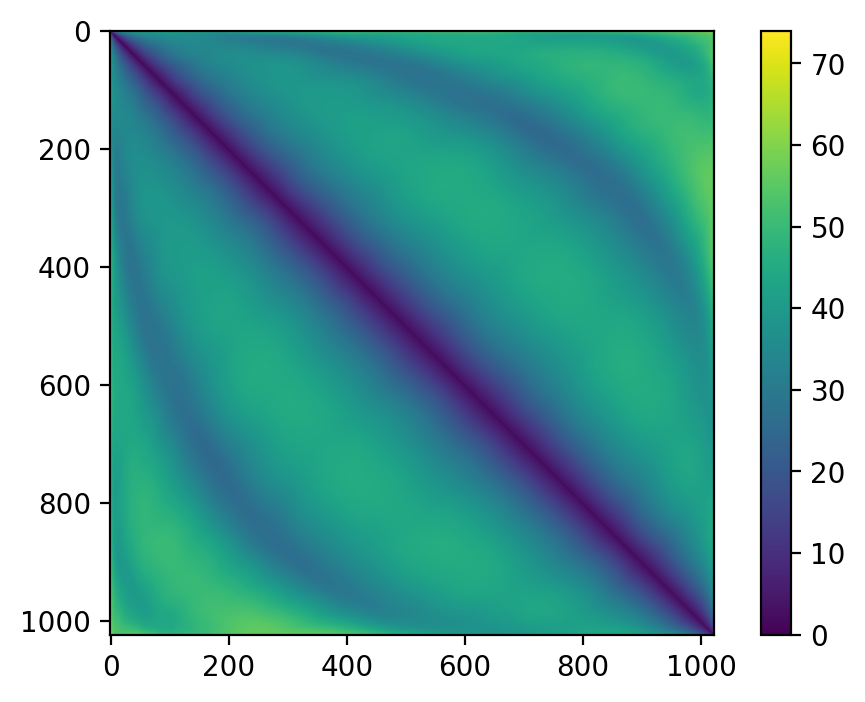

In [70]:
from matplotlib import pyplot as plt

def position_embedding(seq_len, model_pos_embedding, distance='cosine', p = 2):
    pos_ids = t.arange(seq_len)
    pos_emb = model_pos_embedding(pos_ids)

    pos_emb_1 = einops.repeat(pos_emb, "a h -> a b h", b = seq_len)
    pos_emb_2 = einops.repeat(pos_emb, "b h -> a b h", a = seq_len)

    out = None
    if distance == 'cosine':
        out = t.einsum("abh,abh->ab",pos_emb_1, pos_emb_2)/(t.linalg.norm(pos_emb_1, dim=-1)  * t.linalg.norm(pos_emb_2, dim=-1))
    elif distance == 'euclidian':
        out = F.pairwise_distance(pos_emb_1, pos_emb_2, p=p)
    elif 'bad_euclidian':
        out = t.einsum("abh,abh->abh",pos_emb_1, pos_emb_2)
        out = t.pow(t.abs(out), t.tensor(p))
        out = t.einsum("abh->ab", out)
        out = t.pow(out, 1/t.tensor(p))
    # out = out[450:,450:]
    # plt.imshow(t.linalg.norm(pos_emb_1[1000:,1000:], dim=-1).detach())
    # print(t.linalg.norm(pos_emb_1[-1,-1], dim=-1).detach())
    # plt.colorbar()
    # plt.show()
    return out
    # return (out - t.min(out)) / t.max(out)

    

out = position_embedding(1024,gpt2.wpe,'cdist', p=1)
# out = position_embedding(512,model.pos_embedding, 'euclidian', p=2)
# out = (t.abs(out) > 3.7)
out = out.detach().numpy()
plt.figure(dpi=200)
plt.imshow(out[1:,1:])

plt.colorbar()

In [97]:
# simulating random vectors
x = t.randn(10000,768)
y = t.randn(10000,768)
print(t.mean((abs(t.nn.CosineSimilarity()(x,y))<0.1).type(t.float)))

tensor(0.9952)


In [4]:
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2Model.from_pretrained('gpt2')


In [41]:
model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP

0.02968132

# Identifying attention heads that read and write to the same subspace 

torch.Size([8, 32, 256]) torch.Size([8, 50259, 256])
tensor([[  2.3100,   3.8415,   2.4474,   2.4208,   3.9813,   2.6073,   1.8919,
           2.8991],
        [  3.3418,   2.9996,   2.8629,   5.0999,   3.1195,   2.8733,   2.6414,
           3.5918],
        [  4.2973,   4.7713,   4.7328,   3.9711,   4.4826,  12.7444,   7.1990,
           5.9039],
        [  3.3350,   3.4760,   4.1194,   3.1518,   2.5779,   3.7192,   2.6245,
           3.9417],
        [  5.2498,   4.7719,   8.3644,   3.5305,   3.8630,   5.7582,   4.5054,
           5.7354],
        [  4.7208,   5.7524,   6.3839,   4.2323,   4.0211,   6.8857,   4.4910,
           5.5393],
        [  3.6416,   4.6371,   5.4065,   2.8048,   3.4184,   7.1140,   4.4574,
           4.9305],
        [  3.5939,   3.2589,   3.0323,   4.8420,   3.0436,   3.2826,   2.6347,
           3.5663],
        [615.6138, 526.2084, 598.1690, 638.4881, 797.6082, 686.0162, 946.2702,
         551.2534]], grad_fn=<CatBackward0>)


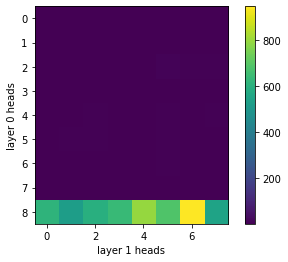

In [82]:
def plotting_ov(model):
    num_heads = model.blocks[0].n_heads
    hidden_size = model.blocks[0].hidden_size
    head_size = model.blocks[0].head_size
    batches, seq_len = test_tokens.shape
    
    # heads in layer 0
    o = model.blocks[0].project_output.weight
    o = einops.rearrange(o, 'hidden_size (num_heads head_size) -> num_heads hidden_size head_size',
                         num_heads=num_heads, head_size=head_size)
    repeated_o = einops.repeat(o, 'num_heads hidden_size head_size -> num_heads new hidden_size head_size', new=num_heads)
    
    # heads in layer 1
    qkv1 = model.blocks[1].project_qkv.weight
    q1, k1, v1 = einops.rearrange(qkv1, '(qkv num_heads head_size) hidden_size -> qkv num_heads head_size hidden_size',
                                  qkv=3, num_heads=num_heads, head_size=head_size)
    reader = v1
    repeated_reader = einops.repeat(reader, 'num_heads head_size hidden_size -> new num_heads head_size hidden_size', new=num_heads)

    matrices = t.einsum('orij,orjk->orik', repeated_reader, repeated_o)
    norms = t.linalg.norm(matrices, dim=(-2,-1))

    # original token embedding
    emb = einops.repeat(model.token_embedding.weight, 'hidden_size vocab_size -> num_heads hidden_size vocab_size',
                        num_heads = num_heads)
    # check if layer 1 is reading from the token embedding subspace
    print(reader.shape, emb.shape)
    reader_emb_matrices = t.einsum('npc,nvc->nvp', reader, emb)
    reader_emb_norms = t.linalg.norm(reader_emb_matrices, dim=(-2,-1)).unsqueeze(0)
    norms = t.cat((norms, reader_emb_norms), dim=0)

    return norms

    # v * o, with shape (8, 8, head_size, head_size)
    # output shape (8, 8)
    
    

norms = plotting_ov(model)
print(norms)
plt.imshow(norms.detach())
plt.xlabel('layer 1 heads')
plt.ylabel('layer 0 heads')
plt.colorbar()
